In [1]:
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris

In [17]:
#Naive Bayes Classifier Class
class NBC:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.num_real_features = np.count_nonzero(np.array(feature_types) == 'r', axis=0)
        self.num_bin_features = np.count_nonzero(np.array(feature_types) == 'b', axis=0)
        self.var_smoothing = var_smoothing = 1e-5
        
        #Identify columns for binary values
        self.bin_features = []
        for i in range(len(feature_types)):
            if feature_types[i] == 'b':
                self.bin_features.append(i)
        
    def fit(self, X, y):
        #Add column of ones
        #ones = np.array([[1]])
        #for i in range(len(X) - 1):
        #    ones = np.append(ones, [np.array([1])], axis=0)
        #X = np.append(ones, X, axis=1)
        
        #Separate real and binary features
        X_bin = X[:,self.bin_features]
        X_real = np.delete(X, self.bin_features, axis=1)

        #Init all mu's, sigma's, theta's, priors, and class counts to 0 for all features and classes
        self.mus = np.zeros((self.num_classes, self.num_real_features))
        self.sigmas = np.zeros((self.num_classes, self.num_real_features))
        self.thetas = np.zeros((self.num_classes, self.num_bin_features))
        self.class_counts = np.zeros(self.num_classes)
        self.class_priors = np.zeros(self.num_classes)
        
        #First handle real valued features assuming Normal distributions
        #Separate X values by classes
        self.classes = np.unique(y)
        for y_i in self.classes:
            i = self.classes.searchsorted(y_i) #index of class, needed below
            X_real_i = X_real[y == y_i, :]
            
            #Update number of data points with this class label
            self.class_counts[i] += len(X_real_i)
            
            #Get means and variances for features of that class
            mu = np.mean(X_real_i, axis=0)
            sigma = np.var(X_real_i, axis=0)
            
            self.mus[i, :] = mu
            self.sigmas[i, :] = sigma
        
        #Smooth variances so they are not exactly 0
        self.sigmas[:, :] += self.var_smoothing
        
        #Now let's handle binary valued features assuming Bernoulli distribution
        for y_i in self.classes:
            i = self.classes.searchsorted(y_i)
            X_bin_i = X_bin[y == y_i, :]
            
            #Get bernoulli prob that feature=1 for that class
            theta = np.count_nonzero(X_bin_i, axis=0) / len(X_bin_i) 
            self.thetas[i, :] = theta
            
        #Smooth variances so they are not exactly 0
        self.thetas[:, :] += self.var_smoothing
            
        #Define priors to be frequency of class in dataset
        self.class_priors = self.class_counts / self.class_counts.sum()
        
        return self
    
    #Preditc classes for points in X given the fitted model
    def predict(self, X):
        #Obtain log likelihoods for each class
        log_likelihoods = self.log_likelihoods(X)
        
        #Return the class with highest log likelihood
        i = np.argmax(log_likelihoods, axis=0)
        return self.classes[i]
    
    #Calculates log likelihood for each class of the given model assuming normal distributions
    def log_likelihoods(self, X):
        #Split into real valued and binary valued features
        X_bin = X[:,self.bin_features]
        X_real = np.delete(X, self.bin_features, axis=1)
        log_likelihoods = []
        
        for i in range(self.num_classes):
            prior = np.log(self.class_priors[i])
            normal = 0
            bern = 0
            if self.sigmas.size != 0:
                normal = - 0.5 * np.sum(np.log(self.sigmas[i, :] * 2. * np.pi)) - 0.5 * np.sum(((X_real - self.mus[i, :]) ** 2) / (self.sigmas[i, :]), 1)
            if self.thetas.size != 0:
                bern = np.log(np.sum(X_bin * (self.thetas[i, :]) + (1 - X_bin) * (1 - self.thetas[i, :]), 1))
            log_likelihoods.append(prior + normal + bern)
        
        log_likelihoods = np.array(log_likelihoods)
        return log_likelihoods

In [18]:
test = NBC(feature_types = ['r', 'r', 'r'], num_classes = 2)
X = np.array([[1, 1, 1], [4, 1, 1], [7, 0, 0]])
y = np.array([1, 1, 2])
test.fit(X, y)
test.predict(np.array([[1, 1, 1], [7, 1, 0]]))

array([1, 2])

C is the inverse of the regularization strength. So, as the sklearn webpage explains, no regularization means a very high value of C. If we want λwTw regularization with λ = 0.1, that means we would want to choose our sklearn model to have l2 penalty with C = 5 as the sklearn model already multiplies its regularization term by a factor of 0.5.

In [19]:
#Load in iris data
iris = load_iris()
X, y = iris['data'], iris['target']

In [21]:
#Keep track of error rates for every iteration
all_log_error_rates = []
all_NBC_error_rates = []
iterations = 200

#Iterate enough times, then take averages of error rates
for i in range(1, iterations + 1):
    #Shuffle data and split it 80/20
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]

    log_error_rates = []
    NBC_error_rates = []

    #10 loops where we use k * 10% of total training data
    for k in range(1, 11):
        Ntrain_subset = int(k * 0.1 * Ntrain)
        Xtrain_subset = Xtrain[:Ntrain_subset]
        ytrain_subset = ytrain[:Ntrain_subset]

        #Fit logistic regression and get error rate
        log_clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(Xtrain_subset, ytrain_subset)
        log_prediction = log_clf.predict(Xtest)
        log_error_rate = (len(ytest) - np.sum(ytest == log_prediction)) / (len(ytest))
        log_error_rates.append(log_error_rate)
        
        #Fit NBC and get error rate
        NBC_clf = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3).fit(Xtrain_subset, ytrain_subset)
        NBC_prediction = NBC_clf.predict(Xtest)
        NBC_error_rate = (len(ytest) - np.sum(ytest == NBC_prediction)) / (len(ytest))
        NBC_error_rates.append(NBC_error_rate)
        
    #Add list of all 10 error rates to list of all error rates for both models
    all_log_error_rates.append(log_error_rates)
    all_NBC_error_rates.append(NBC_error_rates)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


In [22]:
#Get average error rates for each K used over all iterations
all_log_error_rates = np.array(all_log_error_rates)
avg_log_error_rates = np.sum(all_log_error_rates, axis=0) / iterations

all_NBC_error_rates = np.array(all_NBC_error_rates)
avg_NBC_error_rates = np.sum(all_NBC_error_rates, axis=0) / iterations

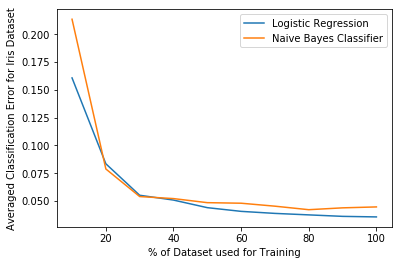

In [23]:
#Plot error rates as function of size of training set
log_error_plot, = plt.plot(range(10, 110, 10), avg_log_error_rates, label='Logistic Regression')
NBC_error_plot, = plt.plot(range(10, 110, 10), avg_NBC_error_rates, label='Naive Bayes Classifier')
plt.legend(handles=[log_error_plot, NBC_error_plot])
plt.xlabel('% of Dataset used for Training')
plt.ylabel('Averaged Classification Error for Iris Dataset')
plt.show()

In [24]:
X, y = cp.load(open('voting.pickle', 'rb'))

In [26]:
#Keep track of error rates for every iteration
all_log_error_rates = []
all_NBC_error_rates = []
iterations = 200

#Iterate enough times, then take averages of error rates
for i in range(1, iterations + 1):
    #Shuffle data and split it 80/20
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]

    log_error_rates = []
    NBC_error_rates = []

    #10 loops where we use k * 10% of total training data
    for k in range(1, 11):
        Ntrain_subset = int(k * 0.1 * Ntrain)
        Xtrain_subset = Xtrain[:Ntrain_subset]
        ytrain_subset = ytrain[:Ntrain_subset]

        #Fit logistic regression and get error rate
        log_clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(Xtrain_subset, ytrain_subset)
        log_prediction = log_clf.predict(Xtest)
        log_error_rate = (len(ytest) - np.sum(ytest == log_prediction)) / (len(ytest))
        log_error_rates.append(log_error_rate)
        
        #Fit NBC and get error rate
        NBC_clf = NBC(feature_types=['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], num_classes=2).fit(Xtrain_subset, ytrain_subset)
        NBC_prediction = NBC_clf.predict(Xtest)
        NBC_error_rate = (len(ytest) - np.sum(ytest == NBC_prediction)) / (len(ytest))
        NBC_error_rates.append(NBC_error_rate)
        
    #Add list of all 10 error rates to list of all error rates for both models
    all_log_error_rates.append(log_error_rates)
    all_NBC_error_rates.append(NBC_error_rates)

In [27]:
#Get average error rates for each K used over all iterations
all_log_error_rates = np.array(all_log_error_rates)
avg_log_error_rates = np.sum(all_log_error_rates, axis=0) / iterations

all_NBC_error_rates = np.array(all_NBC_error_rates)
avg_NBC_error_rates = np.sum(all_NBC_error_rates, axis=0) / iterations

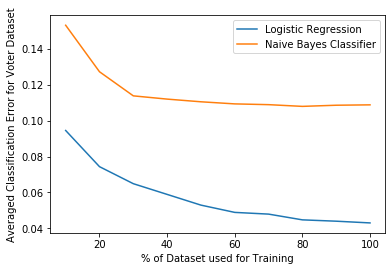

In [28]:
#Plot error rates as function of size of training set
log_error_plot, = plt.plot(range(10, 110, 10), avg_log_error_rates, label='Logistic Regression')
NBC_error_plot, = plt.plot(range(10, 110, 10), avg_NBC_error_rates, label='Naive Bayes Classifier')
plt.legend(handles=[log_error_plot, NBC_error_plot])
plt.xlabel('% of Dataset used for Training')
plt.ylabel('Averaged Classification Error for Voter Dataset')
plt.show()